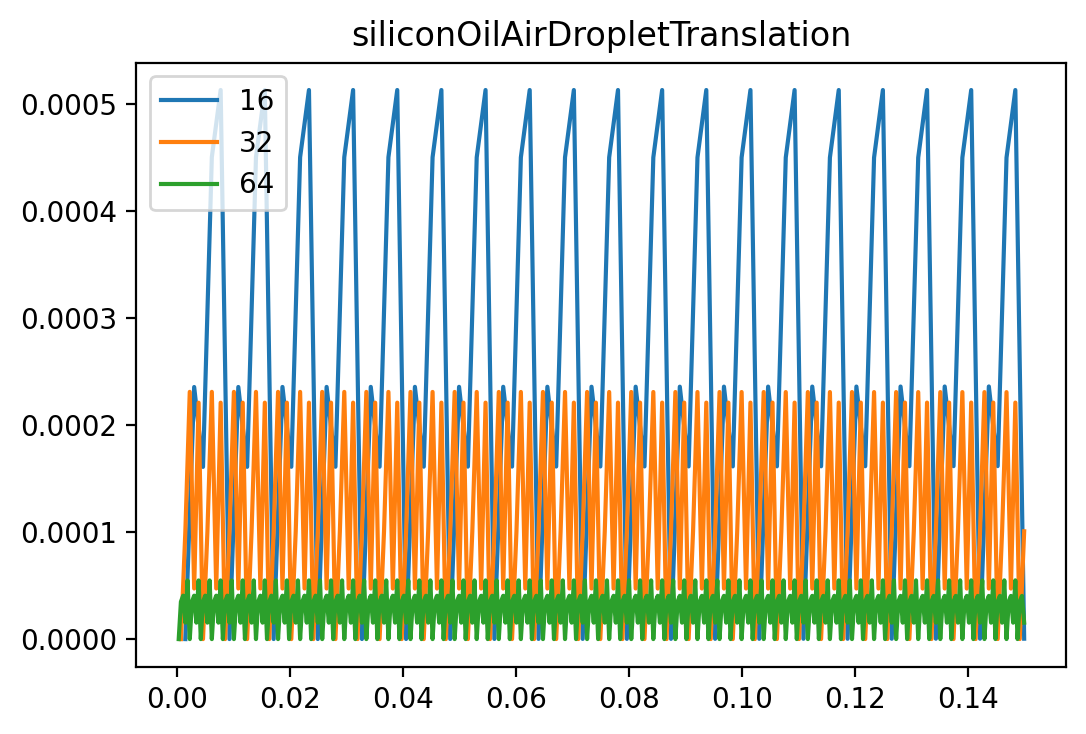

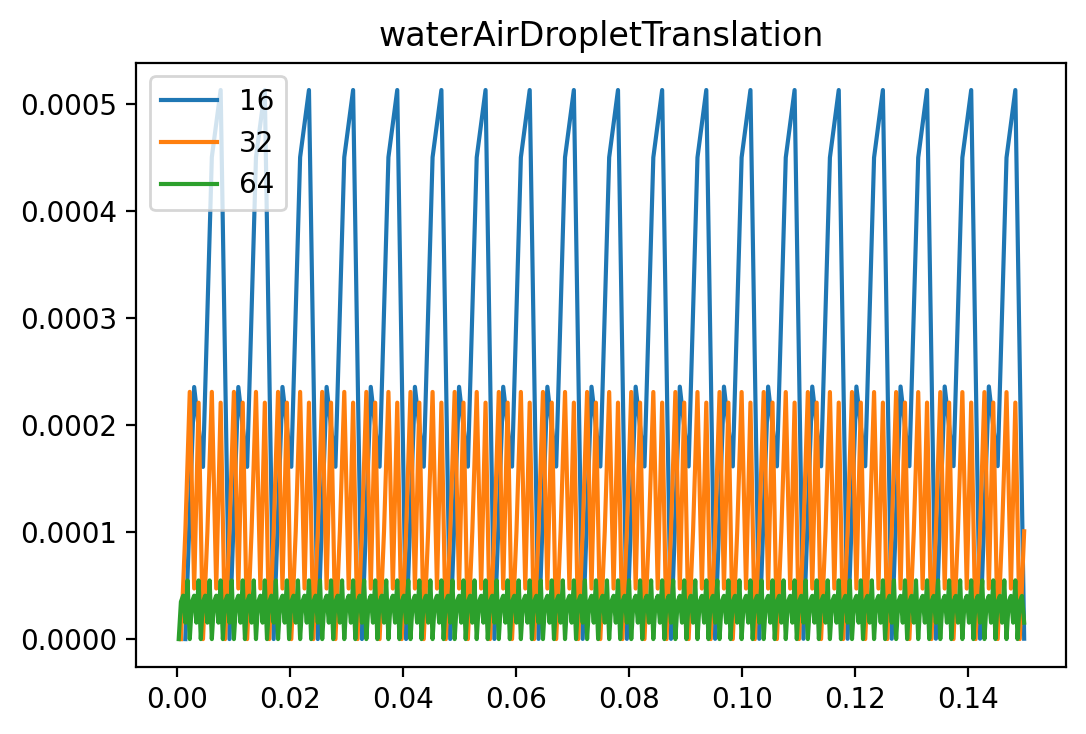

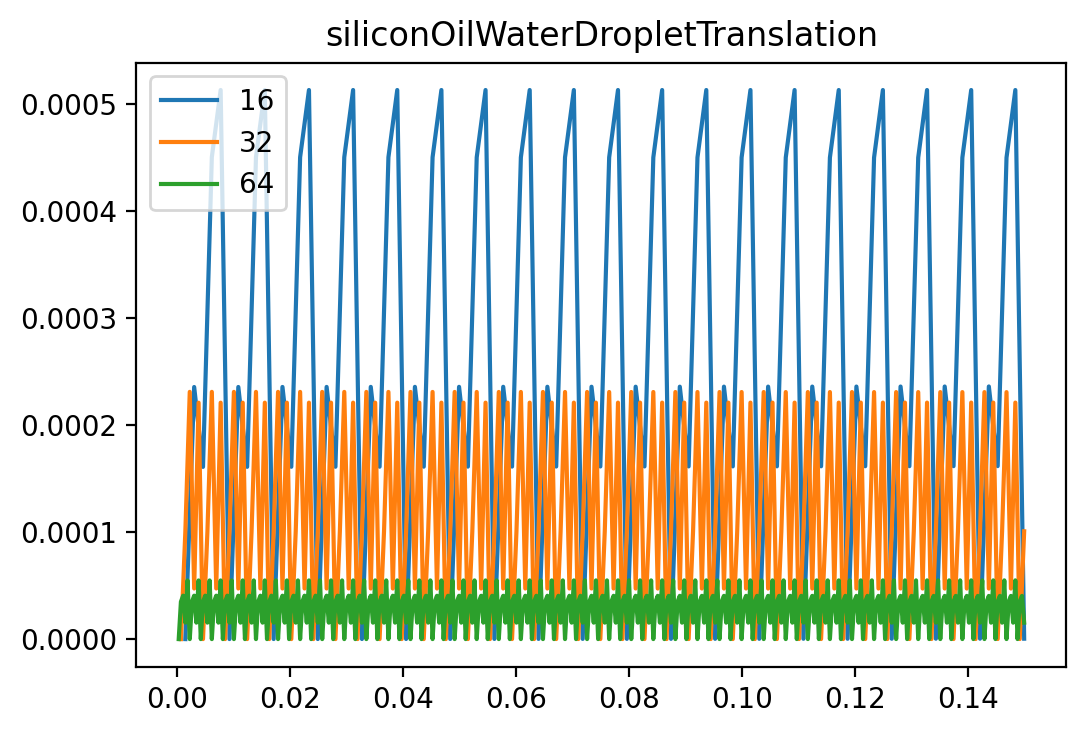

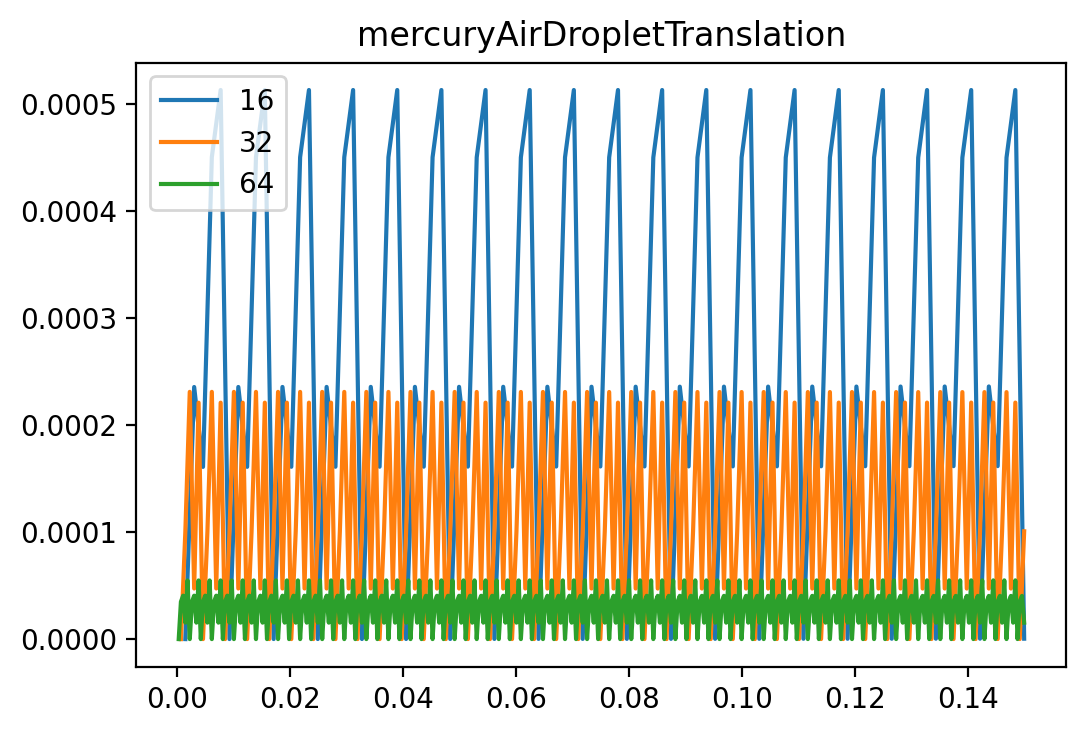

{16: 0.000513122, 32: 0.000231041, 64: 5.48852e-05}


In [82]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams
import ast

rcParams["figure.dpi"] = 200

# Get unique patterns that identify parameter studies
study_patterns = list(set([folder.split(".parameter")[0] for folder in os.listdir(os.curdir) \
                      if os.path.isdir(folder) and "000" in folder]))

data_filename="advectionErrors.dat"

# Find variation files
variation_files = [variation_file for variation_file in os.listdir(os.curdir) \
                   if os.path.isfile(variation_file) and \
                   variation_file.endswith(".variations") and \
                   "default" not in variation_file and \
                   "noMultiphase" not in variation_file]

# Read variation data
variation_dicts = {}
for variation_file in variation_files:
    variation_dict = {}
    with open(variation_file) as data_file:
        data = data_file.readlines()[10:]
        for i,line in enumerate(data):
            variation_dict["VARIATION-%04d" % i] = ast.literal_eval(line.lstrip("Variation %d :" % i))
    variation_dicts[variation_file] = variation_dict
   
vol_conserv_dict = {16 : 0, 32 : 0, 64 :0}

# Process variations        
for study_pattern in study_patterns:
    if ("Translation" in study_pattern):
        # Get all the advectionErrors.dat files
        study_folders = [folder for folder in os.listdir(os.curdir) \
                         if os.path.isdir(folder) and study_pattern in folder \
                         and "000" in folder]
        study_folders.sort()
        data_files  = [os.path.join(folder,data_filename) for folder in study_folders]
        data_files.sort()
        
        pattern_param = study_pattern.split('-')[-1]
        param_dict = {}
        for param_key in variation_dicts.keys():
            if (pattern_param in param_key):
                param_dict = variation_dicts[param_key]
                        
        # Analyze volume conservation
        for idx,data_file in enumerate(data_files):
            dframe = pd.read_table(data_file, header=1, sep=" ",
                                   names=["TIME", "VOLUME_CONSERVATION_ERROR", 
                                            "L1_ADVECTION_EROR", "L1_ADVECTION_ERROR_NORMALIZED"])
            dframe_max_vol_error = dframe["VOLUME_CONSERVATION_ERROR"].max()
            resolution = param_dict["VARIATION-%04d" % idx]['resolution']
            vol_conserv_dict[resolution] = max(vol_conserv_dict[resolution], dframe_max_vol_error)
            plt.plot(dframe["TIME"], dframe["VOLUME_CONSERVATION_ERROR"], label="%d" % resolution)
        plt.title("%s" % study_pattern)
        plt.legend()
        plt.show()
        
print(vol_conserv_dict)